In [27]:
import os
import cv2
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

#from torch import np
from torch.autograd import Variable

from utils import *
from pose_estimation import *
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 加载测试图片

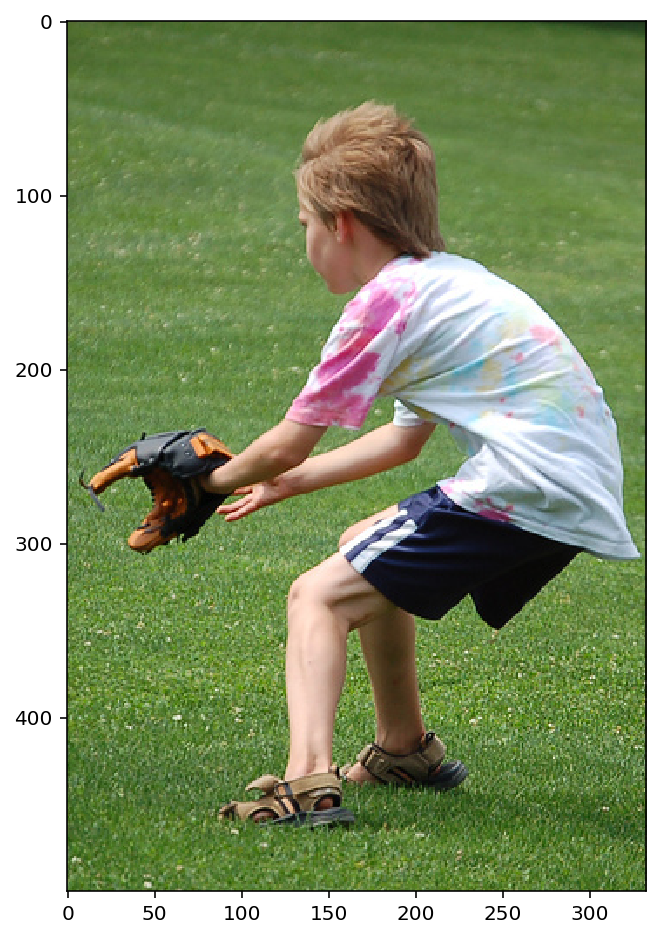

In [28]:
use_gpu = True

test_image = './COCO_val2014_000000000474.jpg'
img_ori = cv2.imread(test_image) # B,G,R order

# display the validation pics
plt.figure(figsize=(12, 8))
plt.imshow(img_ori[...,::-1])

### 加载模型

In [29]:
state_dict = torch.load('./models/coco_pose_iter_440000.pth.tar')['state_dict']

model_pose = get_pose_model()
model_pose.load_state_dict(state_dict)
model_pose.float()
model_pose.eval()

PoseEstimation(
  (model0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU

### 使用 GPU

In [30]:
if use_gpu:
    model_pose.cuda()
    model_pose = torch.nn.DataParallel(model_pose, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

### 获取 PAF 和 Heat Map

In [31]:
%%time

scale_param = [0.5, 1.0, 1.5, 2.0]
paf_info, heatmap_info = get_paf_and_heatmap(model_pose, img_ori, scale_param)

torch.Size([1, 38, 23, 16])
torch.Size([1, 19, 23, 16])


C:\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


torch.Size([1, 38, 46, 31])
torch.Size([1, 19, 46, 31])
torch.Size([1, 38, 69, 46])
torch.Size([1, 19, 69, 46])
torch.Size([1, 38, 92, 62])
torch.Size([1, 19, 92, 62])
Wall time: 1.19 s


### 提取 Heat Map 的关键点

In [32]:
%%time

peaks = extract_heatmap_info(heatmap_info)

Wall time: 523 ms


### 提取 PAF 信息

In [33]:
%%time

sp_k, con_all = extract_paf_info(img_ori, paf_info, peaks)

Wall time: 167 ms


In [34]:
%%time

subsets, candidates = get_subsets(con_all, sp_k, peaks)

Wall time: 997 µs


### 标识关键点

Wall time: 68.8 ms


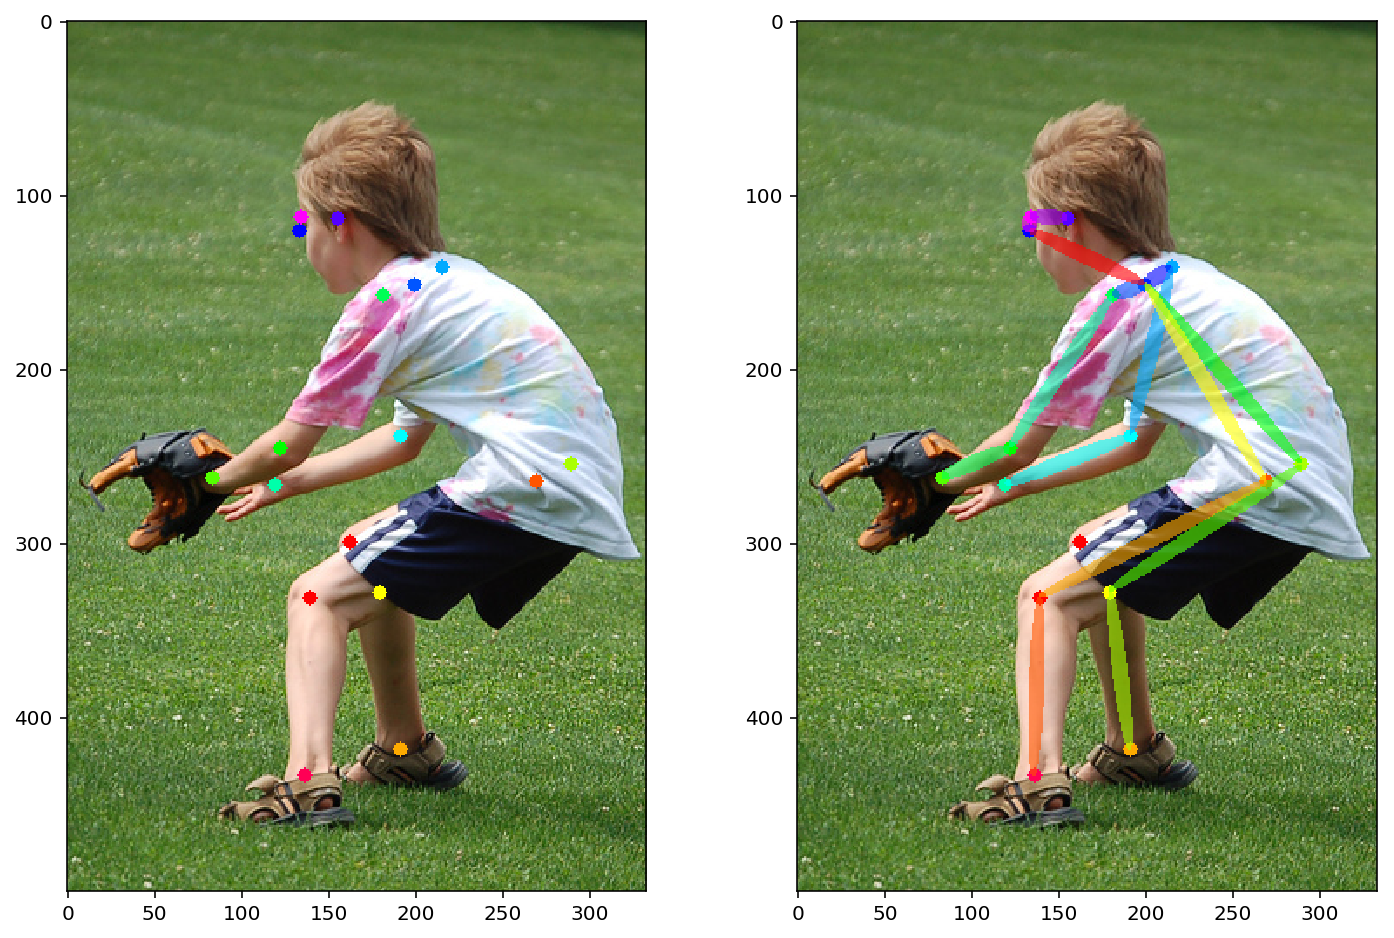

In [35]:
%%time

subsets, img_points = draw_key_point(subsets, peaks, img_ori)
img_canvas = link_key_point(img_points, candidates, subsets)

cv2.imwrite('result.png', img_canvas)   

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_points[...,::-1])

plt.subplot(1, 2, 2)
plt.imshow(img_canvas[...,::-1])